**Benchmarking scAR using public data**
___

In [120]:
#publication quality plots
import seaborn as sns
from matplotlib import pylab

params = {'legend.fontsize': 5,
          'figure.facecolor':"w",
          'figure.figsize': (3, 2),
          'axes.labelsize': 6,
          'axes.titlesize': 6,
         'axes.linewidth': 0.5,
         'xtick.labelsize': 5,
         'ytick.labelsize': 5,
          # set tick width
          'xtick.major.size': 3.5,
          'xtick.major.width': 0.5,
          'xtick.minor.size': 2,
          'xtick.minor.width': 0.5,
          'xtick.color': 'black',
          'ytick.major.size': 3.5,
          'ytick.major.width': 0.5,
          'ytick.minor.size': 2,
          'ytick.minor.width': 0.5,
          'ytick.color': 'black',
         'pdf.fonttype': 42,
         'figure.autolayout': True,
         'axes.grid':False,
         "figure.dpi":200}

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
# pylab.rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10});
pylab.rc('font',**{'family':'sans-serif','sans-serif':['Arial'], 'size':6})

# Set the font used for MathJax - more on this later
# pylab.rc('mathtext',**{'default':'regular'});

pylab.rcParams.update(params);

sns.set_palette("muted");
sns.set_style("ticks");
sns.despine(offset=4, trim=True);

<Figure size 600x400 with 0 Axes>

# Number of trainable parameters

## scAR

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions import Normal, kl_divergence, Multinomial, Binomial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
import scAR

As parameters are dependent of number of features and independent of sample size, we evaluate it with various numbers of features

In [52]:
list_n_features = [100, 500, 1000, 2000, 3000, 4000, 5000, 10000, 20000, 30000]
n_param_df = pd.DataFrame(index = list_n_features, columns=['scAR', 'totalVI', 'scVI', 'DCA']).rename_axis('n_genes')

In [53]:
# generate synthetic data
n_samples = 1000
n_celltypes = 6
np.random.seed(88)

for n_genes in n_param_df.index:

    syn_data = scAR.DataSimulator.CITEseq(n_samples, n_celltypes, n_genes)
    syn_data.generate()
    scARObj = scAR.model(syn_data.obs_count, syn_data.ambient_profile, scRNAseq_tech='CITEseq')
    scARObj.train(epochs=4,
              batch_size=256,)
    
    n_param = 0
    for parameter in scARObj.trained_model.parameters():
        n_param += torch.flatten(parameter).shape[0]
    
    n_param_df.loc[n_genes, 'scAR'] = n_param

..Running VAE using the following param set:
......scAR mode:  CITEseq
......num_input_feature:  100
......NN_layer1:  150
......NN_layer2:  100
......latent_space:  15
......dropout_prob:  0
......kld_weight:  1e-05
......lr:  0.001
......lr_step_size:  5
......lr_gamma:  0.97
  Training.....
100%|██████████| 4/4 [00:00<00:00, 19.38it/s]
..Running VAE using the following param set:
......scAR mode:  CITEseq
......num_input_feature:  500
......NN_layer1:  150
......NN_layer2:  100
......latent_space:  15
......dropout_prob:  0
......kld_weight:  1e-05
......lr:  0.001
......lr_step_size:  5
......lr_gamma:  0.97
  Training.....
100%|██████████| 4/4 [00:00<00:00, 19.91it/s]
..Running VAE using the following param set:
......scAR mode:  CITEseq
......num_input_feature:  1000
......NN_layer1:  150
......NN_layer2:  100
......latent_space:  15
......dropout_prob:  0
......kld_weight:  1e-05
......lr:  0.001
......lr_step_size:  5
......lr_gamma:  0.97
  Training.....
100%|██████████| 4/4 [

## totalVI and scVI

In [54]:
import scvi
import scanpy as sc
import anndata as ad
sc.set_figure_params(figsize=(4, 4))

In [55]:
for n_genes in n_param_df.index:
    syn_data = scAR.DataSimulator.CITEseq(n_samples, n_celltypes, n_genes)
    syn_data.generate()

    adata = ad.AnnData(syn_data.obs_count)
    adata.layers["counts"] = syn_data.obs_count
    sc.pp.normalize_total(adata, target_sum=1e4)

    sc.pp.log1p(adata)
    adata.raw = adata
    adata.obsm['protein_expression'] = syn_data.obs_count[:,:100]

    scvi.model.TOTALVI.setup_anndata(
        adata,
        protein_expression_obsm_key="protein_expression",
        layer="counts",
    )

    totalVI = scvi.model.TOTALVI(adata, latent_distribution="normal")
    totalVI.train(max_epochs=4,
              train_size = 0.5,
              batch_size = 256,
              early_stopping = True,)
    
    n_param = 0
    for parameter in totalVI.module.parameters():
        n_param += torch.flatten(parameter).shape[0]
    n_param_df.loc[n_genes, 'totalVI'] = n_param
    
    scVI = scvi.model.SCVI(adata, latent_distribution="normal")
    scVI.train(max_epochs=4,
              train_size = 0.5,
              batch_size = 256,
              early_stopping = True,)
    
    n_param = 0
    for parameter in scVI.module.parameters():
        n_param += torch.flatten(parameter).shape[0]
    n_param_df.loc[n_genes, 'scVI'] = n_param

INFO     No batch_key inputted, assuming all cells are same batch                            


2022-01-27 18:25:16,770 [INFO] No batch_key inputted, assuming all cells are same batch


INFO     No label_key inputted, assuming all cells have same label                           


2022-01-27 18:25:16,775 [INFO] No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["counts"]                                              


2022-01-27 18:25:16,780 [INFO] Using data from adata.layers["counts"]


INFO     Using protein expression from adata.obsm['protein_expression']                      


2022-01-27 18:25:16,786 [INFO] Using protein expression from adata.obsm['protein_expression']


INFO     Generating sequential protein names                                                 


2022-01-27 18:25:16,789 [INFO] Generating sequential protein names


INFO     Successfully registered anndata object containing 1000 cells, 100 vars, 1 batches, 1
         labels, and 100 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


2022-01-27 18:25:16,792 [INFO] Successfully registered anndata object containing 1000 cells, 100 vars, 1 batches, 1 labels, and 100 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                          


2022-01-27 18:25:16,794 [INFO] Please do not further modify adata until model is trained.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 4/4: 100%|██████████| 4/4 [00:00<00:00, 15.08it/s, loss=2.39e+03, v_num=1]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 4/4: 100%|██████████| 4/4 [00:00<00:00, 25.48it/s, loss=546, v_num=1]
INFO     No batch_key inputted, assuming all cells are same batch                            


2022-01-27 18:25:18,424 [INFO] No batch_key inputted, assuming all cells are same batch


INFO     No label_key inputted, assuming all cells have same label                           


2022-01-27 18:25:18,429 [INFO] No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["counts"]                                              


2022-01-27 18:25:18,433 [INFO] Using data from adata.layers["counts"]


INFO     Using protein expression from adata.obsm['protein_expression']                      


2022-01-27 18:25:18,438 [INFO] Using protein expression from adata.obsm['protein_expression']


INFO     Generating sequential protein names                                                 


2022-01-27 18:25:18,446 [INFO] Generating sequential protein names


INFO     Successfully registered anndata object containing 1000 cells, 500 vars, 1 batches, 1
         labels, and 100 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


2022-01-27 18:25:18,449 [INFO] Successfully registered anndata object containing 1000 cells, 500 vars, 1 batches, 1 labels, and 100 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                          


2022-01-27 18:25:18,452 [INFO] Please do not further modify adata until model is trained.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 4/4: 100%|██████████| 4/4 [00:00<00:00, 13.99it/s, loss=1.73e+03, v_num=1]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]



Epoch 4/4: 100%|██████████| 4/4 [00:00<00:00, 24.57it/s, loss=1.7e+03, v_num=1] 
INFO     No batch_key inputted, assuming all cells are same batch                            


2022-01-27 18:25:19,806 [INFO] No batch_key inputted, assuming all cells are same batch


INFO     No label_key inputted, assuming all cells have same label                           


2022-01-27 18:25:19,811 [INFO] No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["counts"]                                              


2022-01-27 18:25:19,815 [INFO] Using data from adata.layers["counts"]


INFO     Using protein expression from adata.obsm['protein_expression']                      


2022-01-27 18:25:19,824 [INFO] Using protein expression from adata.obsm['protein_expression']


INFO     Generating sequential protein names                                                 


2022-01-27 18:25:19,830 [INFO] Generating sequential protein names


INFO     Successfully registered anndata object containing 1000 cells, 1000 vars, 1 batches, 
         1 labels, and 100 proteins. Also registered 0 extra categorical covariates and 0    
         extra continuous covariates.                                                        


2022-01-27 18:25:19,833 [INFO] Successfully registered anndata object containing 1000 cells, 1000 vars, 1 batches, 1 labels, and 100 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                          


2022-01-27 18:25:19,837 [INFO] Please do not further modify adata until model is trained.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 4/4: 100%|██████████| 4/4 [00:00<00:00, 13.76it/s, loss=2.38e+03, v_num=1]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]



Epoch 4/4: 100%|██████████| 4/4 [00:00<00:00, 23.43it/s, loss=2.31e+03, v_num=1]
INFO     No batch_key inputted, assuming all cells are same batch                            


2022-01-27 18:25:21,264 [INFO] No batch_key inputted, assuming all cells are same batch


INFO     No label_key inputted, assuming all cells have same label                           


2022-01-27 18:25:21,269 [INFO] No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["counts"]                                              


2022-01-27 18:25:21,273 [INFO] Using data from adata.layers["counts"]


INFO     Using protein expression from adata.obsm['protein_expression']                      


2022-01-27 18:25:21,281 [INFO] Using protein expression from adata.obsm['protein_expression']


INFO     Generating sequential protein names                                                 


2022-01-27 18:25:21,288 [INFO] Generating sequential protein names


INFO     Successfully registered anndata object containing 1000 cells, 2000 vars, 1 batches, 
         1 labels, and 100 proteins. Also registered 0 extra categorical covariates and 0    
         extra continuous covariates.                                                        


2022-01-27 18:25:21,293 [INFO] Successfully registered anndata object containing 1000 cells, 2000 vars, 1 batches, 1 labels, and 100 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                          


2022-01-27 18:25:21,297 [INFO] Please do not further modify adata until model is trained.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 4/4: 100%|██████████| 4/4 [00:00<00:00, 11.85it/s, loss=3.05e+03, v_num=1]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 4/4: 100%|██████████| 4/4 [00:00<00:00, 20.59it/s, loss=3.23e+03, v_num=1]
INFO     No batch_key inputted, assuming all cells are same batch                            


2022-01-27 18:25:22,933 [INFO] No batch_key inputted, assuming all cells are same batch


INFO     No label_key inputted, assuming all cells have same label                           


2022-01-27 18:25:22,940 [INFO] No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["counts"]                                              


2022-01-27 18:25:22,944 [INFO] Using data from adata.layers["counts"]


INFO     Using protein expression from adata.obsm['protein_expression']                      


2022-01-27 18:25:22,949 [INFO] Using protein expression from adata.obsm['protein_expression']


INFO     Generating sequential protein names                                                 


2022-01-27 18:25:22,952 [INFO] Generating sequential protein names


INFO     Successfully registered anndata object containing 1000 cells, 3000 vars, 1 batches, 
         1 labels, and 100 proteins. Also registered 0 extra categorical covariates and 0    
         extra continuous covariates.                                                        


2022-01-27 18:25:22,956 [INFO] Successfully registered anndata object containing 1000 cells, 3000 vars, 1 batches, 1 labels, and 100 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                          


2022-01-27 18:25:22,959 [INFO] Please do not further modify adata until model is trained.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 4/4: 100%|██████████| 4/4 [00:00<00:00, 12.93it/s, loss=4.29e+03, v_num=1]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 4/4: 100%|██████████| 4/4 [00:00<00:00, 21.04it/s, loss=4.15e+03, v_num=1]
INFO     No batch_key inputted, assuming all cells are same batch                            


2022-01-27 18:25:24,676 [INFO] No batch_key inputted, assuming all cells are same batch


INFO     No label_key inputted, assuming all cells have same label                           


2022-01-27 18:25:24,681 [INFO] No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["counts"]                                              


2022-01-27 18:25:24,685 [INFO] Using data from adata.layers["counts"]


INFO     Using protein expression from adata.obsm['protein_expression']                      


2022-01-27 18:25:24,692 [INFO] Using protein expression from adata.obsm['protein_expression']


INFO     Generating sequential protein names                                                 


2022-01-27 18:25:24,698 [INFO] Generating sequential protein names


INFO     Successfully registered anndata object containing 1000 cells, 4000 vars, 1 batches, 
         1 labels, and 100 proteins. Also registered 0 extra categorical covariates and 0    
         extra continuous covariates.                                                        


2022-01-27 18:25:24,700 [INFO] Successfully registered anndata object containing 1000 cells, 4000 vars, 1 batches, 1 labels, and 100 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                          


2022-01-27 18:25:24,703 [INFO] Please do not further modify adata until model is trained.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 4/4: 100%|██████████| 4/4 [00:00<00:00, 11.80it/s, loss=4.86e+06, v_num=1]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 4/4: 100%|██████████| 4/4 [00:00<00:00, 18.40it/s, loss=4.37e+03, v_num=1]
INFO     No batch_key inputted, assuming all cells are same batch                            


2022-01-27 18:25:26,618 [INFO] No batch_key inputted, assuming all cells are same batch


INFO     No label_key inputted, assuming all cells have same label                           


2022-01-27 18:25:26,622 [INFO] No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["counts"]                                              


2022-01-27 18:25:26,627 [INFO] Using data from adata.layers["counts"]


INFO     Using protein expression from adata.obsm['protein_expression']                      


2022-01-27 18:25:26,633 [INFO] Using protein expression from adata.obsm['protein_expression']


INFO     Generating sequential protein names                                                 


2022-01-27 18:25:26,640 [INFO] Generating sequential protein names


INFO     Successfully registered anndata object containing 1000 cells, 5000 vars, 1 batches, 
         1 labels, and 100 proteins. Also registered 0 extra categorical covariates and 0    
         extra continuous covariates.                                                        


2022-01-27 18:25:26,644 [INFO] Successfully registered anndata object containing 1000 cells, 5000 vars, 1 batches, 1 labels, and 100 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                          


2022-01-27 18:25:26,646 [INFO] Please do not further modify adata until model is trained.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 4/4: 100%|██████████| 4/4 [00:00<00:00, 11.59it/s, loss=5.72e+03, v_num=1]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 4/4: 100%|██████████| 4/4 [00:00<00:00, 17.19it/s, loss=5.29e+03, v_num=1]
INFO     No batch_key inputted, assuming all cells are same batch                            


2022-01-27 18:25:29,484 [INFO] No batch_key inputted, assuming all cells are same batch


INFO     No label_key inputted, assuming all cells have same label                           


2022-01-27 18:25:29,489 [INFO] No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["counts"]                                              


2022-01-27 18:25:29,493 [INFO] Using data from adata.layers["counts"]


INFO     Using protein expression from adata.obsm['protein_expression']                      


2022-01-27 18:25:29,499 [INFO] Using protein expression from adata.obsm['protein_expression']


INFO     Generating sequential protein names                                                 


2022-01-27 18:25:29,506 [INFO] Generating sequential protein names


INFO     Successfully registered anndata object containing 1000 cells, 10000 vars, 1 batches,
         1 labels, and 100 proteins. Also registered 0 extra categorical covariates and 0    
         extra continuous covariates.                                                        


2022-01-27 18:25:29,512 [INFO] Successfully registered anndata object containing 1000 cells, 10000 vars, 1 batches, 1 labels, and 100 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                          


2022-01-27 18:25:29,516 [INFO] Please do not further modify adata until model is trained.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 4/4: 100%|██████████| 4/4 [00:00<00:00,  9.54it/s, loss=4.85e+06, v_num=1]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 4/4: 100%|██████████| 4/4 [00:00<00:00, 12.64it/s, loss=7.62e+03, v_num=1]
INFO     No batch_key inputted, assuming all cells are same batch                            


2022-01-27 18:25:34,265 [INFO] No batch_key inputted, assuming all cells are same batch


INFO     No label_key inputted, assuming all cells have same label                           


2022-01-27 18:25:34,272 [INFO] No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["counts"]                                              


2022-01-27 18:25:34,275 [INFO] Using data from adata.layers["counts"]


INFO     Using protein expression from adata.obsm['protein_expression']                      


2022-01-27 18:25:34,282 [INFO] Using protein expression from adata.obsm['protein_expression']


INFO     Generating sequential protein names                                                 


2022-01-27 18:25:34,289 [INFO] Generating sequential protein names


INFO     Found batches with missing protein expression                                       


2022-01-27 18:25:34,294 [INFO] Found batches with missing protein expression


INFO     Successfully registered anndata object containing 1000 cells, 20000 vars, 1 batches,
         1 labels, and 100 proteins. Also registered 0 extra categorical covariates and 0    
         extra continuous covariates.                                                        


2022-01-27 18:25:34,297 [INFO] Successfully registered anndata object containing 1000 cells, 20000 vars, 1 batches, 1 labels, and 100 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                          


2022-01-27 18:25:34,300 [INFO] Please do not further modify adata until model is trained.


INFO     Some proteins have all 0 counts in some batches. These proteins will be treated as  
         missing; however, this can occur due to experimental design/biology. Reinitialize   
         the model with `override_missing_proteins=True`,to override this behavior.          


2022-01-27 18:25:34,312 [INFO] Some proteins have all 0 counts in some batches. These proteins will be treated as missing; however, this can occur due to experimental design/biology. Reinitialize the model with `override_missing_proteins=True`,to override this behavior.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 4/4: 100%|██████████| 4/4 [00:00<00:00,  4.84it/s, loss=2.51e+06, v_num=1]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 4/4: 100%|██████████| 4/4 [00:00<00:00,  7.68it/s, loss=8.91e+03, v_num=1]
INFO     No batch_key inputted, assuming all cells are same batch                            


2022-01-27 18:25:41,546 [INFO] No batch_key inputted, assuming all cells are same batch


INFO     No label_key inputted, assuming all cells have same label                           


2022-01-27 18:25:41,552 [INFO] No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["counts"]                                              


2022-01-27 18:25:41,556 [INFO] Using data from adata.layers["counts"]


INFO     Using protein expression from adata.obsm['protein_expression']                      


2022-01-27 18:25:41,566 [INFO] Using protein expression from adata.obsm['protein_expression']


INFO     Generating sequential protein names                                                 


2022-01-27 18:25:41,572 [INFO] Generating sequential protein names


INFO     Found batches with missing protein expression                                       


2022-01-27 18:25:41,577 [INFO] Found batches with missing protein expression


INFO     Successfully registered anndata object containing 1000 cells, 30000 vars, 1 batches,
         1 labels, and 100 proteins. Also registered 0 extra categorical covariates and 0    
         extra continuous covariates.                                                        


2022-01-27 18:25:41,580 [INFO] Successfully registered anndata object containing 1000 cells, 30000 vars, 1 batches, 1 labels, and 100 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                          


2022-01-27 18:25:41,584 [INFO] Please do not further modify adata until model is trained.


INFO     Some proteins have all 0 counts in some batches. These proteins will be treated as  
         missing; however, this can occur due to experimental design/biology. Reinitialize   
         the model with `override_missing_proteins=True`,to override this behavior.          


2022-01-27 18:25:41,596 [INFO] Some proteins have all 0 counts in some batches. These proteins will be treated as missing; however, this can occur due to experimental design/biology. Reinitialize the model with `override_missing_proteins=True`,to override this behavior.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 4/4: 100%|██████████| 4/4 [00:00<00:00,  4.39it/s, loss=9.25e+04, v_num=1]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 4/4: 100%|██████████| 4/4 [00:00<00:00,  5.57it/s, loss=1.06e+04, v_num=1]


## DCA

In [147]:
from dca.api import dca

/da/onc/bfx/research/shengca1/tools/anaconda3/envs/general/lib/python3.8/site-packages/kopt/config.py:60: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  _config = yaml.load(open(_config_path))


In [149]:
dca?

Signature:
dca(
    adata,
    mode='denoise',
    ae_type='nb-conddisp',
    normalize_per_cell=True,
    scale=True,
    log1p=True,
    hidden_size=(64, 32, 64),
    hidden_dropout=0.0,
    batchnorm=True,
    activation='relu',
    init='glorot_uniform',
    network_kwds={},
    epochs=300,
    reduce_lr=10,
    early_stop=15,
    batch_size=32,
    optimizer='RMSprop',
    learning_rate=None,
    random_state=0,
    threads=None,
    verbose=False,
    training_kwds={},
    return_model=False,
    return_info=False,
    copy=False,
    check_counts=True,
)
Docstring:
Deep count autoencoder(DCA) API.

Fits a count autoencoder to the count data given in the anndata object
in order to denoise the data and capture hidden representation of
cells in low dimensions. Type of the autoencoder and return values are
determined by the parameters.

Parameters
----------
adata : :class:`~scanpy.api.AnnData`
    An anndata file with `.raw` attribute representing raw counts.
mode : `str`, optional

In [57]:
for n_genes in n_param_df.index:
    syn_data = scAR.DataSimulator.CITEseq(n_samples, n_celltypes, n_genes)
    syn_data.generate()
    count_matrix = syn_data.obs_count + 1
    adata = ad.AnnData(count_matrix)
    dca_model = dca(adata, threads=28, epochs=4, return_model=True)
    n_param_df.loc[n_genes, 'DCA'] = dca_model.model.count_params()

dca: Successfully preprocessed 100 genes and 1000 cells.


/da/onc/bfx/research/shengca1/tools/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


dca: Calculating reconstructions...
dca: Successfully preprocessed 500 genes and 1000 cells.


/da/onc/bfx/research/shengca1/tools/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


dca: Calculating reconstructions...
dca: Successfully preprocessed 1000 genes and 1000 cells.


/da/onc/bfx/research/shengca1/tools/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


dca: Calculating reconstructions...
dca: Successfully preprocessed 2000 genes and 1000 cells.


/da/onc/bfx/research/shengca1/tools/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


dca: Calculating reconstructions...
dca: Successfully preprocessed 3000 genes and 1000 cells.


/da/onc/bfx/research/shengca1/tools/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


dca: Calculating reconstructions...
dca: Successfully preprocessed 4000 genes and 1000 cells.


/da/onc/bfx/research/shengca1/tools/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


dca: Calculating reconstructions...
dca: Successfully preprocessed 5000 genes and 1000 cells.


/da/onc/bfx/research/shengca1/tools/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


dca: Calculating reconstructions...
dca: Successfully preprocessed 10000 genes and 1000 cells.


/da/onc/bfx/research/shengca1/tools/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


dca: Calculating reconstructions...
dca: Successfully preprocessed 20000 genes and 1000 cells.


/da/onc/bfx/research/shengca1/tools/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


dca: Calculating reconstructions...
dca: Successfully preprocessed 30000 genes and 1000 cells.


/da/onc/bfx/research/shengca1/tools/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


dca: Calculating reconstructions...


In [58]:
n_param_df.to_pickle('../data/benchmarking_num_params.pickle')

In [67]:
n_param_df.div(n_param_df['DCA'],axis=0).mean()

scAR       1.735482
totalVI    7.021084
scVI       3.252913
DCA        1.000000
dtype: float64

In [42]:
n_param_df = n_param_df.stack().to_frame('n_params').rename_axis(['n_genes', 'meth'])
n_param_df = n_param_df.reset_index()
n_param_df['n_genes'] = n_param_df['n_genes'].astype('str')

2022-01-27 18:10:09,291 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2022-01-27 18:10:09,298 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


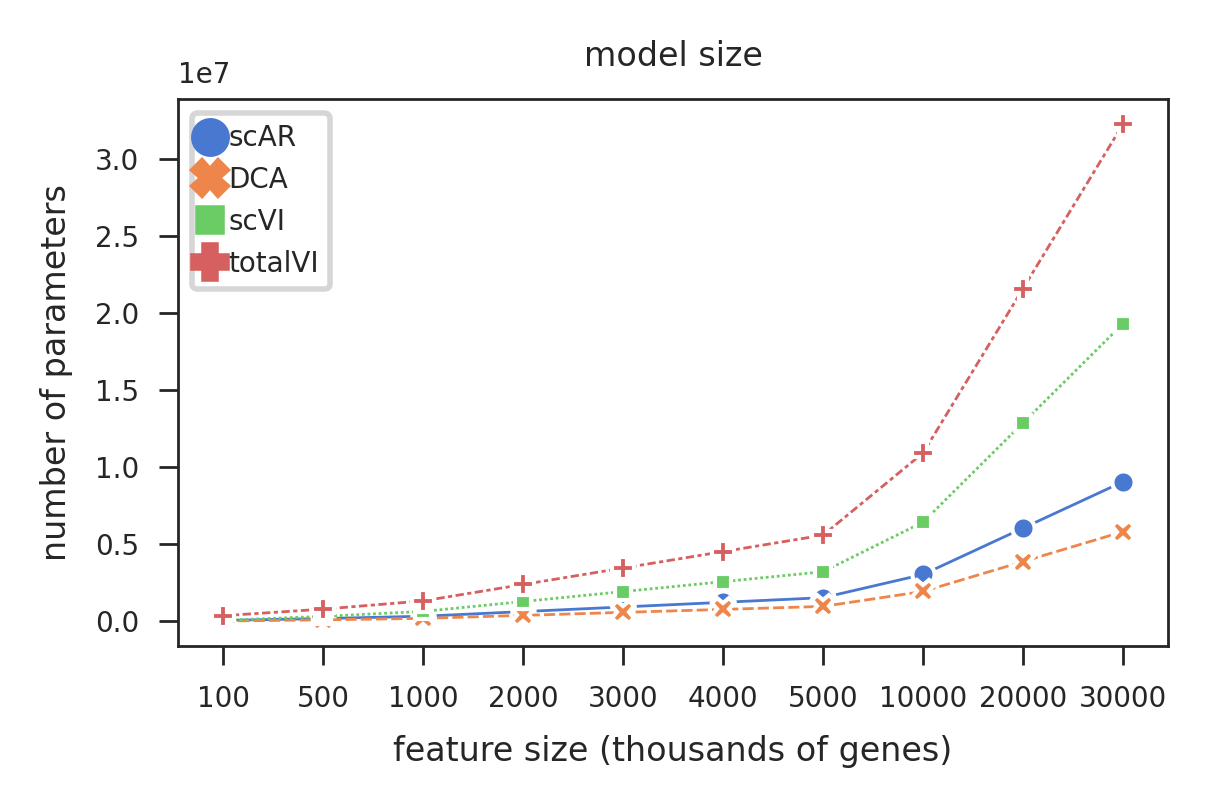

In [49]:
plt.figure(figsize=(3,2))
ax = sns.lineplot(data=n_param_df,
                  x='n_genes',
                  y = 'n_params',
                  hue='meth',hue_order=['scAR', 'DCA', 'scVI', 'totalVI'],
                  style='meth',
                  style_order=['scAR', 'DCA', 'scVI', 'totalVI'],
                  linewidth = 0.5,
                  markersize=4,
                  markers=True,
                  dashes=True
                 );
ax.set_title('model size')
ax.set(xlabel='feature size (thousands of genes)', ylabel='number of parameters')
ax.legend(fontsize=5, title='')
# ax.set_ylim([0,5e6])
for lh in ax.legend_.legendHandles: 
    lh._sizes = [1]
plt.savefig('../../ods-scar/manuscript/figures/benchmarking_num_parameter1.pdf')

# Runtime and memory usage

Check systems

In [68]:
import psutil
import platform
from datetime import datetime

In [72]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU E5-2690 v4 @ 2.60GHz
stepping	: 1
microcode	: 0xb00002e
cpu MHz		: 1269.848
cache size	: 35840 KB
physical id	: 0
siblings	: 14
core id		: 0
cpu cores	: 14
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 20
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc aperfmperf eagerfpu pni pclmulqdq dtes64 monitor ds_cpl vmx smx est tm2 ssse3 sdbg fma cx16 xtpr pdcm pcid dca sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand lahf_lm abm 3dnowprefetch epb cat_l3 cdp_l3 invpcid_single intel_pt ssbd ibrs ibpb stibp tpr_shadow vnmi flexpriority ept vpid fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm cqm rdt_a rdseed adx smap xsaveopt cqm_llc cqm_o

In [69]:
def get_size(bytes, suffix="B"):
    """
    Scale bytes to its proper format
    e.g:
        1253656 => '1.20MB'
        1253656678 => '1.17GB'
    """
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor

In [70]:
print("="*40, "System Information", "="*40)
uname = platform.uname()
print(f"System: {uname.system}")
print(f"Node Name: {uname.node}")
print(f"Release: {uname.release}")
print(f"Version: {uname.version}")
print(f"Machine: {uname.machine}")
print(f"Processor: {uname.processor}")

# Boot Time
print("="*40, "Boot Time", "="*40)
boot_time_timestamp = psutil.boot_time()
bt = datetime.fromtimestamp(boot_time_timestamp)
print(f"Boot Time: {bt.year}/{bt.month}/{bt.day} {bt.hour}:{bt.minute}:{bt.second}")

# let's print CPU information
print("="*40, "CPU Info", "="*40)
# number of cores
print("Physical cores:", psutil.cpu_count(logical=False))
print("Total cores:", psutil.cpu_count(logical=True))
# CPU frequencies
cpufreq = psutil.cpu_freq()
print(f"Max Frequency: {cpufreq.max:.2f}Mhz")
print(f"Min Frequency: {cpufreq.min:.2f}Mhz")
print(f"Current Frequency: {cpufreq.current:.2f}Mhz")
# CPU usage
print("CPU Usage Per Core:")
for i, percentage in enumerate(psutil.cpu_percent(percpu=True, interval=1)):
    print(f"Core {i}: {percentage}%")
print(f"Total CPU Usage: {psutil.cpu_percent()}%")

# Memory Information
print("="*40, "Memory Information", "="*40)
# get the memory details
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}")
print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}")
print(f"Percentage: {svmem.percent}%")
print("="*20, "SWAP", "="*20)
# get the swap memory details (if exists)
swap = psutil.swap_memory()
print(f"Total: {get_size(swap.total)}")
print(f"Free: {get_size(swap.free)}")
print(f"Used: {get_size(swap.used)}")
print(f"Percentage: {swap.percent}%")

# Disk Information
print("="*40, "Disk Information", "="*40)
print("Partitions and Usage:")
# get all disk partitions
partitions = psutil.disk_partitions()
for partition in partitions:
    print(f"=== Device: {partition.device} ===")
    print(f"  Mountpoint: {partition.mountpoint}")
    print(f"  File system type: {partition.fstype}")
    try:
        partition_usage = psutil.disk_usage(partition.mountpoint)
    except PermissionError:
        # this can be catched due to the disk that
        # isn't ready
        continue
    print(f"  Total Size: {get_size(partition_usage.total)}")
    print(f"  Used: {get_size(partition_usage.used)}")
    print(f"  Free: {get_size(partition_usage.free)}")
    print(f"  Percentage: {partition_usage.percent}%")
# get IO statistics since boot
disk_io = psutil.disk_io_counters()
print(f"Total read: {get_size(disk_io.read_bytes)}")
print(f"Total write: {get_size(disk_io.write_bytes)}")

# Network information
print("="*40, "Network Information", "="*40)
# get all network interfaces (virtual and physical)
if_addrs = psutil.net_if_addrs()
for interface_name, interface_addresses in if_addrs.items():
    for address in interface_addresses:
        print(f"=== Interface: {interface_name} ===")
        if str(address.family) == 'AddressFamily.AF_INET':
            print(f"  IP Address: {address.address}")
            print(f"  Netmask: {address.netmask}")
            print(f"  Broadcast IP: {address.broadcast}")
        elif str(address.family) == 'AddressFamily.AF_PACKET':
            print(f"  MAC Address: {address.address}")
            print(f"  Netmask: {address.netmask}")
            print(f"  Broadcast MAC: {address.broadcast}")
# get IO statistics since boot
net_io = psutil.net_io_counters()
print(f"Total Bytes Sent: {get_size(net_io.bytes_sent)}")
print(f"Total Bytes Received: {get_size(net_io.bytes_recv)}")

======================================== System Information ========================================
System: Linux
Node Name: chbscl-0-38
Release: 3.10.0-1160.45.1.el7.x86_64
Version: #1 SMP Wed Oct 13 17:20:51 UTC 2021
Machine: x86_64
Processor: x86_64
======================================== Boot Time ========================================
Boot Time: 2021/12/8 10:20:1
======================================== CPU Info ========================================
Physical cores: 28
Total cores: 28
Max Frequency: 3500.00Mhz
Min Frequency: 1200.00Mhz
Current Frequency: 1419.45Mhz
CPU Usage Per Core:
Core 0: 0.0%
Core 1: 1.0%
Core 2: 0.0%
Core 3: 0.0%
Core 4: 0.0%
Core 5: 0.0%
Core 6: 0.0%
Core 7: 0.0%
Core 8: 0.0%
Core 9: 6.1%
Core 10: 0.0%
Core 11: 2.0%
Core 12: 1.0%
Core 13: 1.0%
Core 14: 0.0%
Core 15: 0.0%
Core 16: 0.0%
Core 17: 0.0%
Core 18: 1.0%
Core 19: 0.0%
Core 20: 0.0%
Core 21: 7.0%
Core 22: 0.0%
Core 23: 75.0%
Core 24: 0.0%
Core 25: 0.0%
Core 26: 0.0%
Core 27: 2.0%
Total CPU Usag

In [71]:
!nvidia-smi

Thu Jan 27 19:03:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:03:00.0 Off |                    0 |
| N/A   28C    P0    32W / 250W |    955MiB / 16280MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  On   | 00000000:04:00.0 Off |                    0 |
| N/A   

In [7]:
import time

preparing data

In [ ]:
brain_data_1M = sc.read_10x_h5('/da/onc/bfx/research/shengca1/public_data/10xgenomics/Brain1.3M/1M_neurons_filtered_gene_bc_matrices_h5.h5')
sc.pp.filter_genes(brain_data_1M, min_counts=500)
sc.pp.filter_cells(brain_data_1M, min_genes=200)
brain_data_1M_backup = brain_data_1M.copy()
sc.pp.normalize_total(brain_data_1M, target_sum=1e4)
sc.pp.log1p(brain_data_1M)
sc.pp.highly_variable_genes(brain_data_1M, n_top_genes=700, inplace=True)
brain_data_1M_HVG = brain_data_1M_backup[:,brain_data_1M.var['highly_variable']]
brain_data_1M_HVG.write('../data/1M_neurons_filtered_700_HVG.h5ad')

In [8]:
brain_data_1M_HVG = sc.read_h5ad('../data/1M_neurons_filtered_5k_HVG.h5ad')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [9]:
number_of_cells = [1, 5, 10, 20, 40, 60, 80, 100] #
n_time_df = pd.DataFrame(index = number_of_cells, columns=['scAR', 'scVI', 'DCA']).rename_axis('n_cells')

number_of_cells = [1, 5, 10, 20, 40, 60, 80, 100]
n_memory_df = pd.DataFrame(index = number_of_cells, columns=['scAR', 'scVI', 'DCA']).rename_axis('n_cells')

## scAR

In [10]:
for n_obs in n_time_df.index:
    adata = sc.pp.subsample(brain_data_1M_HVG, n_obs=n_obs*1000, random_state=0, copy=True)
    scARObj = scAR.model(adata.X.toarray(), scRNAseq_tech='scRNAseq')
    
    torch.cuda.empty_cache()
    start_time = time.time()
    scARObj.train(epochs=100,
                  train_size = 0.99,
                  batch_size=128,
                 )
    n_time_df.loc[n_obs, 'scAR'] = time.time() - start_time
    peak_usage = torch.cuda.max_memory_allocated()/1024**2
    n_memory_df.loc[n_obs, 'scAR'] = peak_usage
    print(f"==> Peak: {peak_usage:.3f} Mb")
    del scARObj
    torch.cuda.reset_max_memory_allocated()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 ... Evaluate empty profile from cells
..Running VAE using the following param set:
......scAR mode:  scRNAseq
......num_input_feature:  5000
......NN_layer1:  150
......NN_layer2:  100
......latent_space:  15
......dropout_prob:  0
......kld_weight:  1e-05
......lr:  0.001
......lr_step_size:  5
......lr_gamma:  0.97
  Training.....
100%|██████████| 100/100 [00:07<00:00, 13.82it/s]

/da/onc/bfx/research/shengca1/tools/anaconda3/envs/general/lib/python3.8/site-packages/torch/cuda/memory.py:271: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
Variable names are not unique. To make them unique, call `.var_names_make_unique`.



==> Peak: 107.254 Mb
 ... Evaluate empty profile from cells
..Running VAE using the following param set:
......scAR mode:  scRNAseq
......num_input_feature:  5000
......NN_layer1:  150
......NN_layer2:  100
......latent_space:  15
......dropout_prob:  0
......kld_weight:  1e-05
......lr:  0.001
......lr_step_size:  5
......lr_gamma:  0.97
  Training.....
100%|██████████| 100/100 [00:32<00:00,  3.04it/s]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.



==> Peak: 260.055 Mb
 ... Evaluate empty profile from cells
..Running VAE using the following param set:
......scAR mode:  scRNAseq
......num_input_feature:  5000
......NN_layer1:  150
......NN_layer2:  100
......latent_space:  15
......dropout_prob:  0
......kld_weight:  1e-05
......lr:  0.001
......lr_step_size:  5
......lr_gamma:  0.97
  Training.....
100%|██████████| 100/100 [01:03<00:00,  1.57it/s]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.



==> Peak: 448.724 Mb
 ... Evaluate empty profile from cells
..Running VAE using the following param set:
......scAR mode:  scRNAseq
......num_input_feature:  5000
......NN_layer1:  150
......NN_layer2:  100
......latent_space:  15
......dropout_prob:  0
......kld_weight:  1e-05
......lr:  0.001
......lr_step_size:  5
......lr_gamma:  0.97
  Training.....
100%|██████████| 100/100 [02:12<00:00,  1.33s/it]
==> Peak: 831.359 Mb


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 ... Evaluate empty profile from cells
..Running VAE using the following param set:
......scAR mode:  scRNAseq
......num_input_feature:  5000
......NN_layer1:  150
......NN_layer2:  100
......latent_space:  15
......dropout_prob:  0
......kld_weight:  1e-05
......lr:  0.001
......lr_step_size:  5
......lr_gamma:  0.97
  Training.....
100%|██████████| 100/100 [04:14<00:00,  2.55s/it]
==> Peak: 1593.133 Mb


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 ... Evaluate empty profile from cells
..Running VAE using the following param set:
......scAR mode:  scRNAseq
......num_input_feature:  5000
......NN_layer1:  150
......NN_layer2:  100
......latent_space:  15
......dropout_prob:  0
......kld_weight:  1e-05
......lr:  0.001
......lr_step_size:  5
......lr_gamma:  0.97
  Training.....
100%|██████████| 100/100 [06:14<00:00,  3.75s/it]
==> Peak: 2356.072 Mb


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 ... Evaluate empty profile from cells
..Running VAE using the following param set:
......scAR mode:  scRNAseq
......num_input_feature:  5000
......NN_layer1:  150
......NN_layer2:  100
......latent_space:  15
......dropout_prob:  0
......kld_weight:  1e-05
......lr:  0.001
......lr_step_size:  5
......lr_gamma:  0.97
  Training.....
100%|██████████| 100/100 [08:32<00:00,  5.12s/it]
==> Peak: 3119.254 Mb


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 ... Evaluate empty profile from cells
..Running VAE using the following param set:
......scAR mode:  scRNAseq
......num_input_feature:  5000
......NN_layer1:  150
......NN_layer2:  100
......latent_space:  15
......dropout_prob:  0
......kld_weight:  1e-05
......lr:  0.001
......lr_step_size:  5
......lr_gamma:  0.97
  Training.....
100%|██████████| 100/100 [10:25<00:00,  6.25s/it]
==> Peak: 3883.254 Mb


## scVI

In [11]:
for n_obs in n_time_df.index:

    adata = sc.pp.subsample(brain_data_1M_HVG, n_obs=n_obs*1000, random_state=0, copy=True)
    
    adata.layers["counts"] = adata.X.toarray() + 1
    scvi.model.SCVI.setup_anndata(adata,
                                  layer="counts",
    )
    
    scVI = scvi.model.SCVI(adata)
    start_time = time.time()
    scVI.train(max_epochs=100,
               train_size = 0.99,
               batch_size = 128,
               early_stopping_patience = 99,
               early_stopping = True,)
    
    n_time_df.loc[n_obs, 'scVI'] = time.time() - start_time
    
    peak_usage = torch.cuda.max_memory_allocated()/1024**2
    n_memory_df.loc[n_obs, 'scVI'] = peak_usage
    print(f"==> Peak: {peak_usage:.3f} Mb")
    del scVI
    torch.cuda.empty_cache()
    torch.cuda.reset_max_memory_allocated()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


INFO     No batch_key inputted, assuming all cells are same batch                            


2022-01-27 15:57:36,382 [INFO] No batch_key inputted, assuming all cells are same batch


INFO     No label_key inputted, assuming all cells have same label                           


2022-01-27 15:57:36,393 [INFO] No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["counts"]                                              


2022-01-27 15:57:36,396 [INFO] Using data from adata.layers["counts"]


INFO     Successfully registered anndata object containing 1000 cells, 5000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


2022-01-27 15:57:36,408 [INFO] Successfully registered anndata object containing 1000 cells, 5000 vars, 1 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                          


2022-01-27 15:57:36,410 [INFO] Please do not further modify adata until model is trained.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 100/100: 100%|██████████| 100/100 [00:09<00:00, 10.76it/s, loss=6.97e+03, v_num=1]
==> Peak: 95.427 Mb


/da/onc/bfx/research/shengca1/tools/anaconda3/envs/general/lib/python3.8/site-packages/torch/cuda/memory.py:271: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


INFO     No batch_key inputted, assuming all cells are same batch                            


2022-01-27 15:57:45,908 [INFO] No batch_key inputted, assuming all cells are same batch


INFO     No label_key inputted, assuming all cells have same label                           


2022-01-27 15:57:45,913 [INFO] No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["counts"]                                              


2022-01-27 15:57:45,916 [INFO] Using data from adata.layers["counts"]


INFO     Successfully registered anndata object containing 5000 cells, 5000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


2022-01-27 15:57:45,922 [INFO] Successfully registered anndata object containing 5000 cells, 5000 vars, 1 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                          


2022-01-27 15:57:45,925 [INFO] Please do not further modify adata until model is trained.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 100/100: 100%|██████████| 100/100 [00:39<00:00,  2.56it/s, loss=5.8e+03, v_num=1]

/da/onc/bfx/research/shengca1/tools/anaconda3/envs/general/lib/python3.8/site-packages/torch/cuda/memory.py:271: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
Variable names are not unique. To make them unique, call `.var_names_make_unique`.



==> Peak: 130.949 Mb
INFO     No batch_key inputted, assuming all cells are same batch                            


2022-01-27 15:58:25,269 [INFO] No batch_key inputted, assuming all cells are same batch


INFO     No label_key inputted, assuming all cells have same label                           


2022-01-27 15:58:25,275 [INFO] No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["counts"]                                              


2022-01-27 15:58:25,279 [INFO] Using data from adata.layers["counts"]


INFO     Successfully registered anndata object containing 10000 cells, 5000 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


2022-01-27 15:58:25,287 [INFO] Successfully registered anndata object containing 10000 cells, 5000 vars, 1 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                          


2022-01-27 15:58:25,290 [INFO] Please do not further modify adata until model is trained.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 100/100: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s, loss=5.57e+03, v_num=1]

/da/onc/bfx/research/shengca1/tools/anaconda3/envs/general/lib/python3.8/site-packages/torch/cuda/memory.py:271: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
Variable names are not unique. To make them unique, call `.var_names_make_unique`.



==> Peak: 166.487 Mb
INFO     No batch_key inputted, assuming all cells are same batch                            


2022-01-27 15:59:37,442 [INFO] No batch_key inputted, assuming all cells are same batch


INFO     No label_key inputted, assuming all cells have same label                           


2022-01-27 15:59:37,449 [INFO] No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["counts"]                                              


2022-01-27 15:59:37,453 [INFO] Using data from adata.layers["counts"]


INFO     Successfully registered anndata object containing 20000 cells, 5000 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


2022-01-27 15:59:37,460 [INFO] Successfully registered anndata object containing 20000 cells, 5000 vars, 1 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                          


2022-01-27 15:59:37,463 [INFO] Please do not further modify adata until model is trained.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 100/100: 100%|██████████| 100/100 [02:26<00:00,  1.46s/it, loss=5.53e+03, v_num=1]
==> Peak: 202.100 Mb


/da/onc/bfx/research/shengca1/tools/anaconda3/envs/general/lib/python3.8/site-packages/torch/cuda/memory.py:271: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


INFO     No batch_key inputted, assuming all cells are same batch                            


2022-01-27 16:02:04,338 [INFO] No batch_key inputted, assuming all cells are same batch


INFO     No label_key inputted, assuming all cells have same label                           


2022-01-27 16:02:04,345 [INFO] No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["counts"]                                              


2022-01-27 16:02:04,349 [INFO] Using data from adata.layers["counts"]


INFO     Successfully registered anndata object containing 40000 cells, 5000 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


2022-01-27 16:02:04,358 [INFO] Successfully registered anndata object containing 40000 cells, 5000 vars, 1 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                          


2022-01-27 16:02:04,361 [INFO] Please do not further modify adata until model is trained.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 100/100: 100%|██████████| 100/100 [04:52<00:00,  2.92s/it, loss=5.52e+03, v_num=1]
==> Peak: 131.481 Mb


/da/onc/bfx/research/shengca1/tools/anaconda3/envs/general/lib/python3.8/site-packages/torch/cuda/memory.py:271: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


INFO     No batch_key inputted, assuming all cells are same batch                            


2022-01-27 16:06:57,890 [INFO] No batch_key inputted, assuming all cells are same batch


INFO     No label_key inputted, assuming all cells have same label                           


2022-01-27 16:06:57,901 [INFO] No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["counts"]                                              


2022-01-27 16:06:57,906 [INFO] Using data from adata.layers["counts"]


INFO     Successfully registered anndata object containing 60000 cells, 5000 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


2022-01-27 16:06:57,918 [INFO] Successfully registered anndata object containing 60000 cells, 5000 vars, 1 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                          


2022-01-27 16:06:57,921 [INFO] Please do not further modify adata until model is trained.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 100/100: 100%|██████████| 100/100 [07:26<00:00,  4.47s/it, loss=5.52e+03, v_num=1]
==> Peak: 131.768 Mb


/da/onc/bfx/research/shengca1/tools/anaconda3/envs/general/lib/python3.8/site-packages/torch/cuda/memory.py:271: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


INFO     No batch_key inputted, assuming all cells are same batch                            


2022-01-27 16:14:26,220 [INFO] No batch_key inputted, assuming all cells are same batch


INFO     No label_key inputted, assuming all cells have same label                           


2022-01-27 16:14:26,228 [INFO] No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["counts"]                                              


2022-01-27 16:14:26,234 [INFO] Using data from adata.layers["counts"]


INFO     Successfully registered anndata object containing 80000 cells, 5000 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


2022-01-27 16:14:26,244 [INFO] Successfully registered anndata object containing 80000 cells, 5000 vars, 1 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                          


2022-01-27 16:14:26,247 [INFO] Please do not further modify adata until model is trained.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 100/100: 100%|██████████| 100/100 [09:09<00:00,  5.49s/it, loss=5.52e+03, v_num=1]
==> Peak: 132.087 Mb


/da/onc/bfx/research/shengca1/tools/anaconda3/envs/general/lib/python3.8/site-packages/torch/cuda/memory.py:271: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


INFO     No batch_key inputted, assuming all cells are same batch                            


2022-01-27 16:23:37,640 [INFO] No batch_key inputted, assuming all cells are same batch


INFO     No label_key inputted, assuming all cells have same label                           


2022-01-27 16:23:37,648 [INFO] No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["counts"]                                              


2022-01-27 16:23:37,654 [INFO] Using data from adata.layers["counts"]


INFO     Successfully registered anndata object containing 100000 cells, 5000 vars, 1        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


2022-01-27 16:23:37,661 [INFO] Successfully registered anndata object containing 100000 cells, 5000 vars, 1 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                          


2022-01-27 16:23:37,664 [INFO] Please do not further modify adata until model is trained.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 100/100: 100%|██████████| 100/100 [12:17<00:00,  7.38s/it, loss=5.52e+03, v_num=1]
==> Peak: 132.372 Mb


/da/onc/bfx/research/shengca1/tools/anaconda3/envs/general/lib/python3.8/site-packages/torch/cuda/memory.py:271: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


## DCA

In [14]:
for n_obs in n_time_df.index:
    
    adata = sc.pp.subsample(brain_data_1M_HVG, n_obs=n_obs*1000, random_state=0, copy=True)
    adata.X = adata.X.toarray() + 1
    
    torch.cuda.empty_cache()
    start_time = time.time()
    dca_model = dca(adata,
                    threads=28,
                    epochs=100,
                    early_stop=99,
                    batch_size=128,
                    return_model=True)
    
    n_time_df.loc[n_obs, 'DCA'] = time.time() - start_time

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


dca: Successfully preprocessed 5000 genes and 1000 cells.



2022-01-27 16:39:24,014 [WARNING] From /da/onc/bfx/research/shengca1/tools/anaconda3/envs/general/lib/python3.8/site-packages/dca/train.py:41: The name tf.keras.backend.set_session is deprecated. Please use tf.compat.v1.keras.backend.set_session instead.

/da/onc/bfx/research/shengca1/tools/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


dca: Calculating reconstructions...


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


dca: Successfully preprocessed 5000 genes and 5000 cells.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/da/onc/bfx/research/shengca1/tools/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


dca: Calculating reconstructions...


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


dca: Successfully preprocessed 5000 genes and 10000 cells.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/da/onc/bfx/research/shengca1/tools/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


dca: Calculating reconstructions...


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


dca: Successfully preprocessed 5000 genes and 20000 cells.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/da/onc/bfx/research/shengca1/tools/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


dca: Calculating reconstructions...


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


dca: Successfully preprocessed 5000 genes and 40000 cells.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/da/onc/bfx/research/shengca1/tools/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


dca: Calculating reconstructions...


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


dca: Successfully preprocessed 5000 genes and 60000 cells.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/da/onc/bfx/research/shengca1/tools/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


dca: Calculating reconstructions...


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


dca: Successfully preprocessed 5000 genes and 80000 cells.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/da/onc/bfx/research/shengca1/tools/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


dca: Calculating reconstructions...


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


dca: Successfully preprocessed 5000 genes and 100000 cells.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/da/onc/bfx/research/shengca1/tools/anaconda3/envs/general/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


dca: Calculating reconstructions...


In [17]:
n_time_df.to_pickle('../data/runtime.pickle')

In [50]:
n_time_df = pd.read_pickle('../data/runtime.pickle')
n_time_df = n_time_df/60

In [45]:
n_time_df = n_time_df.stack().to_frame('runtime').rename_axis(['n_cells', 'meth']).reset_index()

n_time_df['n_cells'] = n_time_df['n_cells'].astype('str')

2022-01-27 18:10:34,290 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2022-01-27 18:10:34,297 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


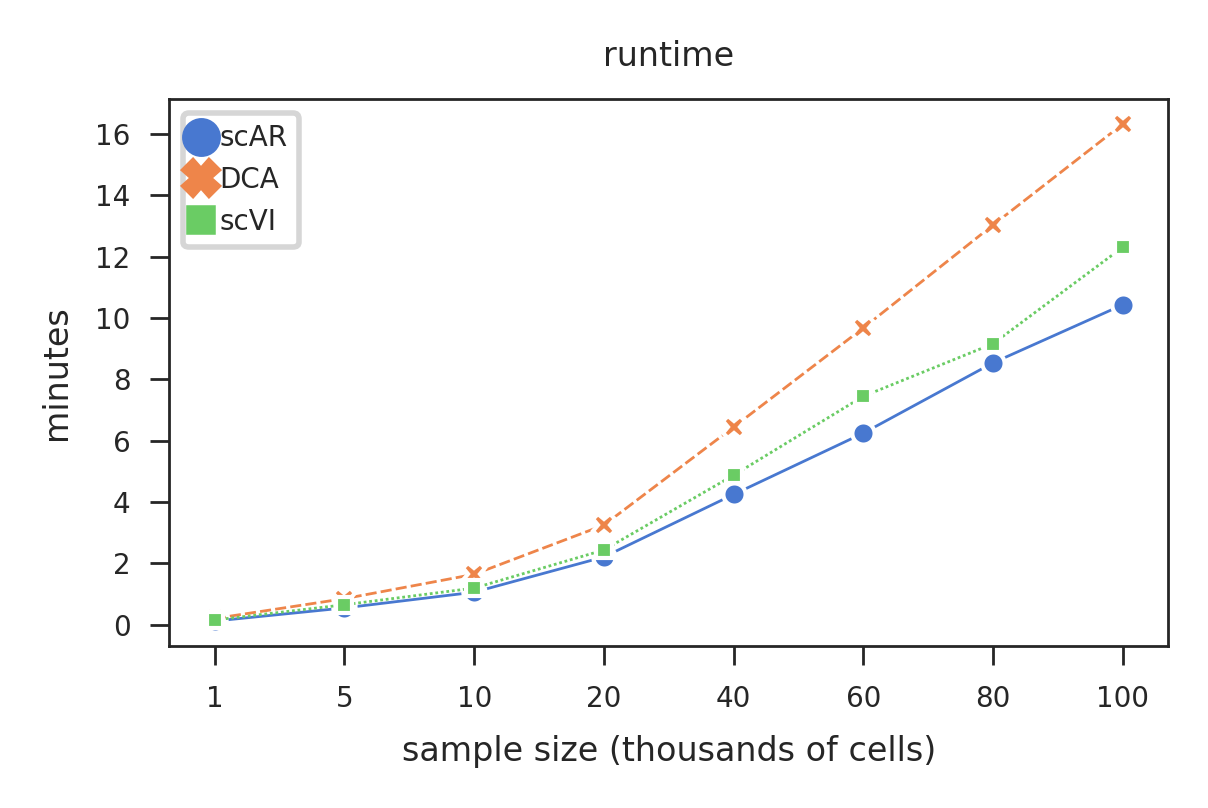

In [50]:
plt.figure(figsize=(3,2))
ax = sns.lineplot(data=n_time_df,
                  x='n_cells',
                  y = 'runtime',
                  hue='meth',
                  hue_order=['scAR', 'DCA', 'scVI'],
                  style='meth',
                  style_order=['scAR', 'DCA', 'scVI'],
                  linewidth = 0.5,
                  markersize=4,
                  markers=True,
                  dashes=True
                 );

ax.set(xlabel='sample size (thousands of cells)', ylabel='minutes', title='runtime')

ax.legend(fontsize=5, title='')
# ax.set_ylim([0,5e6])
for lh in ax.legend_.legendHandles: 
    lh._sizes = [1]
plt.savefig('../../ods-scar/manuscript/figures/benchmarking_runtime.pdf')

In [60]:
n_time_df.div(n_time_df['scAR'], axis=0).mean()

scAR    1.000000
scVI    1.162144
DCA     1.551568
dtype: float64

# Protein-RNA correlation

Preparing benchmarking data

In [81]:
mRNA_list = {'CD86': 'CD86',
            'CD274': 'CD274',
            'CD8a': 'CD8A',
            'CD56': 'CD56',
            'CD19': 'CD19',
            'CD45RA': 'PTPRC',
            'CD4': 'CD4',
            'CD14': 'CD14',
            'CD16': 'FCGR3A',
            'CD25': 'IL2RA',
            'CD45RO': 'PTPRC',
            'TIGIT': 'TIGIT',
            'CD20': 'MS4A1',
            'CD335': 'NCR1',
            'CD69': 'CD69',
            'CD62L': 'SELL',
            'CD197': 'CCR7',
            'CD27': 'CD27',
            'HLA-DR': 'HLA-DRA',
            'CD278': 'ICOS',
            'CD137': 'TNFRSF9',
            'CD28': 'CD28',
            'CD127': 'IL7R',
            'CD86': 'CD86',
            'CD274': 'CD274',
            'CD3': 'CD3D',
            'CD56': 'NCAM1',
            'CD19': 'CD19',
            'CD11b': 'ITGAM',
            'CD15': 'FUT4',
            'CD20': 'CCR7',
            'CD34': 'CD34',
            'CD80': 'CD80',
            'PD-1': 'PDCD1',
            'IgG1_control': 'IGHG1',
            'IgG2a_control': 'IGHG2',
            'IgG2b_control': 'IGHG2',
            }

In [104]:
adata = sc.read_h5ad('../data/5k_pbmc_protein_v3.h5ad')
raw_prot = adata[:,adata.var['feature_types'] == 'Antibody Capture'].to_df()
adata = adata[:,adata.var['feature_types'] == 'Gene Expression']

adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
raw_mRNA = adata[:, list(set(mRNA_list.values()))].to_df()  # Raw counts

sc.pp.log1p(adata)
adata.raw = adata
adata.obsm['protein_expression'] = raw_prot

## scAR

In [83]:
### Denoised counts
denoised_counts = pd.read_csv('/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/CITEseq/5k_pbmc_protein_v3/scAR_out_mRNA/expected_natives.csv', index_col=0)
denoised_fb = pd.read_csv('/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/CITEseq/5k_pbmc_protein_v3/scAR_out_fb/expected_natives.csv', index_col=0)
adata_scAR =  ad.AnnData(denoised_counts)
sc.pp.normalize_total(adata_scAR, target_sum=1e4)

In [84]:
scAR_mRNA = adata_scAR[:, list(set(mRNA_list.values()))].to_df().T
scAR_mRNA['meth'] = 'scAR'
scAR_prot = denoised_fb.copy().T
scAR_prot.index = scAR_prot.index.str.replace('_TotalSeqB','')
scAR_prot['meth'] = 'scAR'

## totalVI

In [11]:
# adata.obsm["X_totalVI"] = vae.get_latent_representation()

# rna, protein = vae.get_normalized_expression(
#     n_samples=25, 
#     return_mean=True, 
#     # transform_batch=["PBMC10k", "PBMC5k"]
# )

# adata.layers["denoised_rna"], adata.obsm["denoised_protein"] = rna, protein

# adata.obsm["protein_foreground_prob"] = vae.get_protein_foreground_probability(
#     n_samples=25, 
#     return_mean=True, 
#     # transform_batch=["PBMC10k", "PBMC5k"]
# )
# parsed_protein_names = [p.split("_")[0] for p in adata.obsm["protein_expression"].columns]
# adata.obsm["protein_foreground_prob"].columns = parsed_protein_names

In [12]:
# protein.to_pickle('/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/CITEseq/5k_pbmc_protein_v3/totalVI/protein.pickle')
# rna.to_pickle('/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/CITEseq/5k_pbmc_protein_v3/totalVI/rna.pickle')

In [13]:
# adata.write('/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/CITEseq/5k_pbmc_protein_v3/totalVI/totalVI_results.h5ad')

In [85]:
adata = sc.read('/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/CITEseq/5k_pbmc_protein_v3/totalVI/totalVI_results.h5ad')

In [86]:
totalVI_mRNA = pd.DataFrame(adata.layers["denoised_rna"], index=adata.obs_names, columns=adata.var_names)
totalVI_mRNA = totalVI_mRNA[list(set(mRNA_list.values()))].T
totalVI_mRNA['meth'] = 'totalVI'

In [87]:
totalVI_prot = adata.obsm['denoised_protein']
totalVI_prot.columns = totalVI_prot.columns.str.replace('_TotalSeqB', '')
totalVI_prot = totalVI_prot.T
totalVI_prot['meth'] = 'totalVI'

## DCA

In [88]:
# read output
dca = pd.read_csv('/da/ONC/bfx/research/shengca1/pipeline/obfx-fbdenoiser/CITEseq/5k_pbmc_protein_v3/dca/mean.tsv', sep='\t', index_col=0)
dca_fb = pd.read_csv('/da/ONC/bfx/research/shengca1/pipeline/obfx-fbdenoiser/CITEseq/5k_pbmc_protein_v3/dca_fb/mean.tsv', sep='\t', index_col=0)

In [89]:
### Denoised counts
adata_dca =  ad.AnnData(dca.T)
sc.pp.normalize_total(adata_dca, target_sum=1e4)
DCA_mRNA = adata_dca[:, list(set(mRNA_list.values()))].to_df()
DCA_mRNA = DCA_mRNA.T
DCA_mRNA['meth'] = 'DCA'
DCA_prot = dca_fb.copy()
DCA_prot.index = DCA_prot.index.str.replace('_TotalSeqB','')
DCA_prot['meth'] = 'DCA'

## Spearman's correlation

In [90]:
from scipy.stats import spearmanr

In [112]:
raw_mRNA = raw_mRNA.T
raw_mRNA['meth']='raw counts'

raw_prot = raw_prot.T
raw_prot['meth']='raw counts'
raw_prot.index = raw_prot.index.str.replace('_TotalSeqB', '')

In [113]:
mRNA = raw_mRNA.append(scAR_mRNA).append(totalVI_mRNA).append(DCA_mRNA).set_index('meth', append=True)
mRNA.index = mRNA.index.reorder_levels([1,0])
mRNA = mRNA.rename_axis(['meth', 'markers'])

PROT = raw_prot.append(scAR_prot).append(totalVI_prot).append(DCA_prot).set_index('meth', append=True)

## Remove several antibodies, comment out for full list of antibodies
idx=pd.IndexSlice
PROT = PROT.drop(index=idx[['IgG1_control','IgG2a_control', 'IgG2b_control', 'CD45RA', 'CD45RO', 
                            'CD15', 'CD34', 'CD80', 'CD137', 'CD274', 'CD278', 'PD-1'
                           ]]) #'CD69', 

PROT.index = PROT.index.reorder_levels([1,0])
PROT = PROT.rename_axis(['meth', 'markers'])

/da/onc/bfx/research/shengca1/tools/anaconda3/envs/general/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [114]:
adata_processed = sc.read('/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/data/CITEseq_5k_PBMCs/processed_adata_20_11_2021.h5ad')
sorted_idx = adata_processed.obs.sort_values('celltype_1').index

PROT = PROT[sorted_idx]
mRNA = mRNA[sorted_idx]

In [115]:
corr_df = pd.DataFrame(index=PROT.index, columns=['corr', 'pval'])

for idx in corr_df.index.unique():
    meth, prot = idx
    sc_protein = PROT.loc[idx]
    sc_mrna = mRNA.loc[idx[0]].loc[mRNA_list[prot]]
    corr_df.loc[idx,['corr','pval']] = spearmanr(sc_protein, sc_mrna, nan_policy='omit')

In [116]:
corr_df_mRNA = pd.DataFrame(index=PROT.index, columns=['corr', 'pval'])

for idx in corr_df_mRNA.index.unique():
    meth, prot = idx
    sc_protein = PROT.loc[('raw counts', prot)]
    sc_mrna = mRNA.loc[idx[0]].loc[mRNA_list[prot]]
    corr_df_mRNA.loc[idx,['corr','pval']] = spearmanr(sc_protein, sc_mrna, nan_policy='omit')

In [117]:
corr_df_prot = pd.DataFrame(index=PROT.index, columns=['corr', 'pval'])

for idx in corr_df_prot.index.unique():
    meth, prot = idx
    sc_protein = PROT.loc[idx]
    sc_mrna = mRNA.loc[('raw counts', mRNA_list[prot])]
    corr_df_prot.loc[idx,['corr','pval']] = spearmanr(sc_protein, sc_mrna, nan_policy='omit')

In [118]:
corr_df['denoising'] = 'both'
corr_df_prot['denoising'] = 'protein'
corr_df_mRNA['denoising'] = 'mRNA'

corr_all = corr_df.append(corr_df_prot).append(corr_df_mRNA)

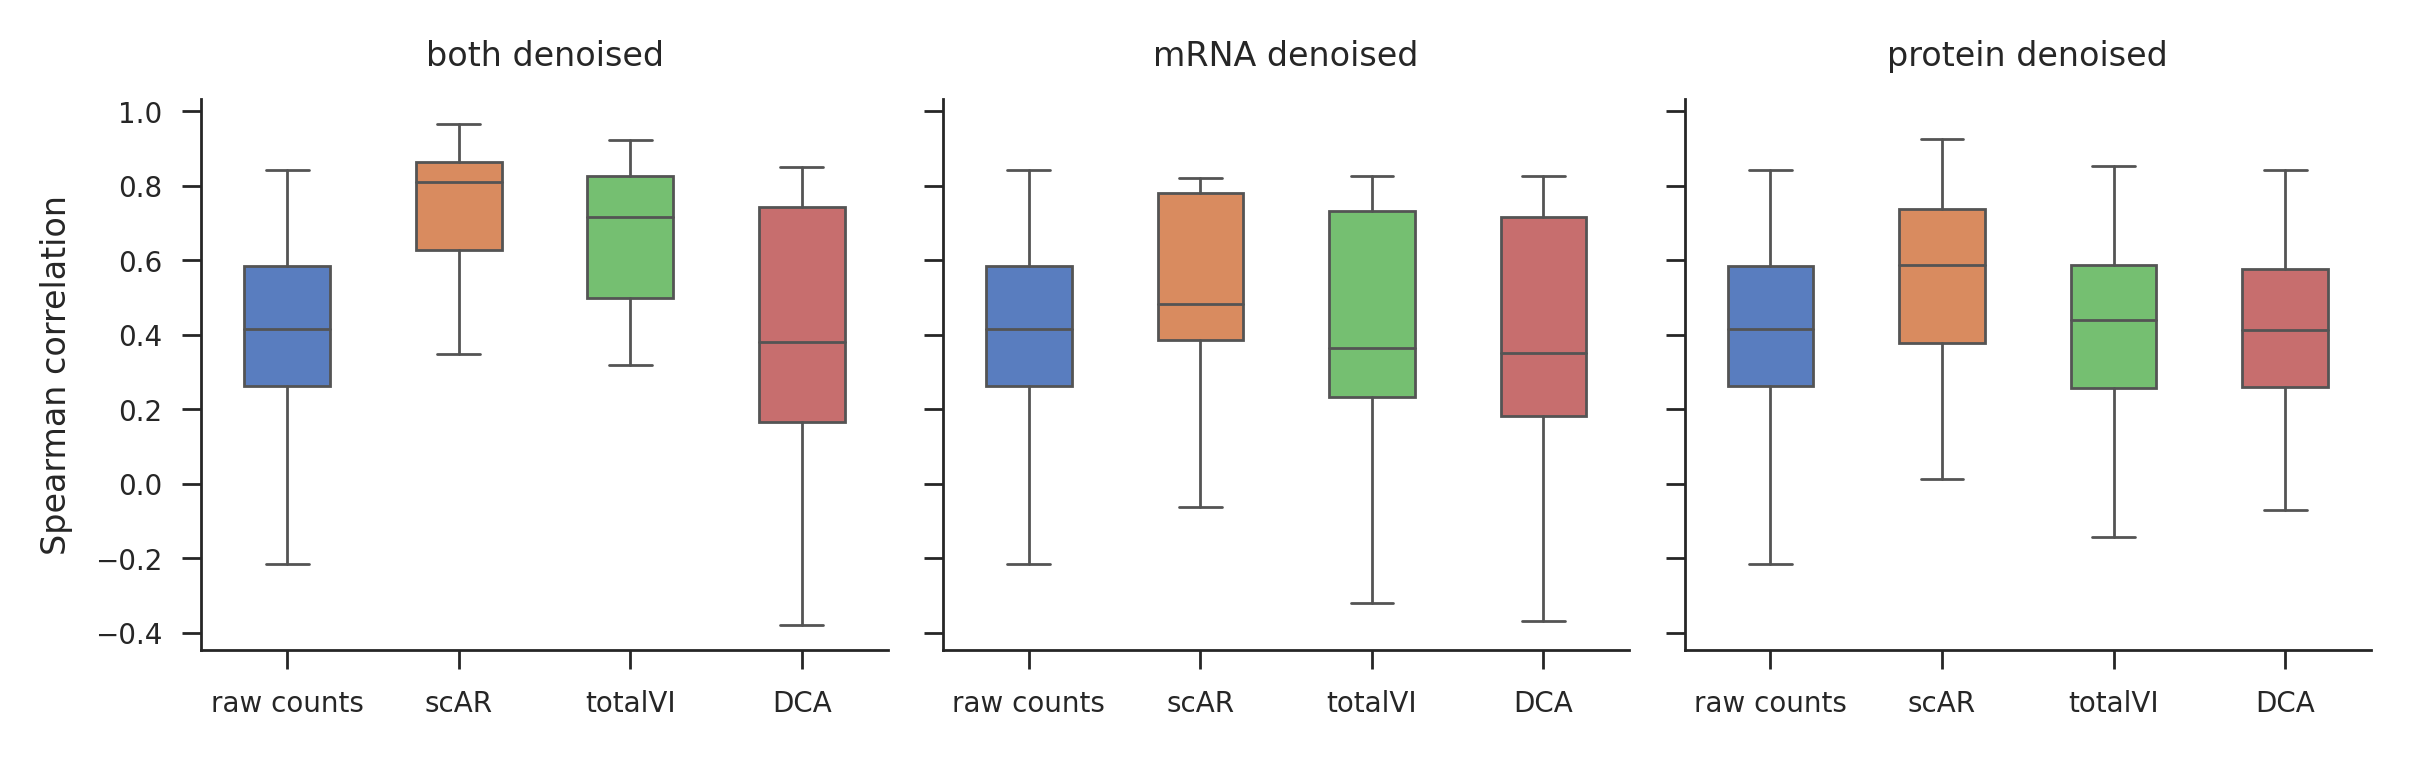

In [129]:
ax = sns.catplot(x = 'meth',
                 y = 'corr',
                 data=corr_all.reset_index(),
                 col='denoising', col_order=['both', 'mRNA', 'protein'],
                 height=2, aspect=1,
                 kind="box", dodge=True,
                 width=0.5, showfliers=False, linewidth=0.5,
                );
ax.set(xlabel='', ylabel='Spearman correlation');
ax.set_titles('{col_name} denoised')
# ax.set_xticklabels(ax.get_xticklabel(), rotation=45, ha='right')
plt.savefig('/da/ONC/bfx/research/shengca1/pipeline/ods-scar/manuscript/figures/Fig5.benchmarking/boxplot_protein_RNA_correlation_denoised_27_01_2022.pdf')

In [144]:
corr_scatterplot = corr_all.reset_index()
corr_scatterplot = corr_scatterplot[corr_scatterplot['denoising']=='both'][['meth', 'markers', 'corr']]
corr_scatterplot = corr_scatterplot.pivot(index='markers', columns=['meth'])
corr_scatterplot.columns = corr_scatterplot.columns.droplevel(0)
tmp = corr_scatterplot[['scAR', 'totalVI', 'DCA']].unstack().to_frame('corr').reset_index().set_index('markers')
corr_scatterplot = tmp.join(corr_scatterplot[['raw counts']], how='left')

corr_scatterplot = corr_scatterplot.reset_index()
corr_scatterplot = corr_scatterplot.fillna(0)
corr_scatterplot.head()

,markers,meth,corr,raw counts
0,CD11b,scAR,0.862868,0.564060
1,CD11b,totalVI,0.910040,0.564060
2,CD11b,DCA,0.849173,0.564060
3,CD127,scAR,0.862684,0.790089
4,CD127,totalVI,0.915809,0.790089


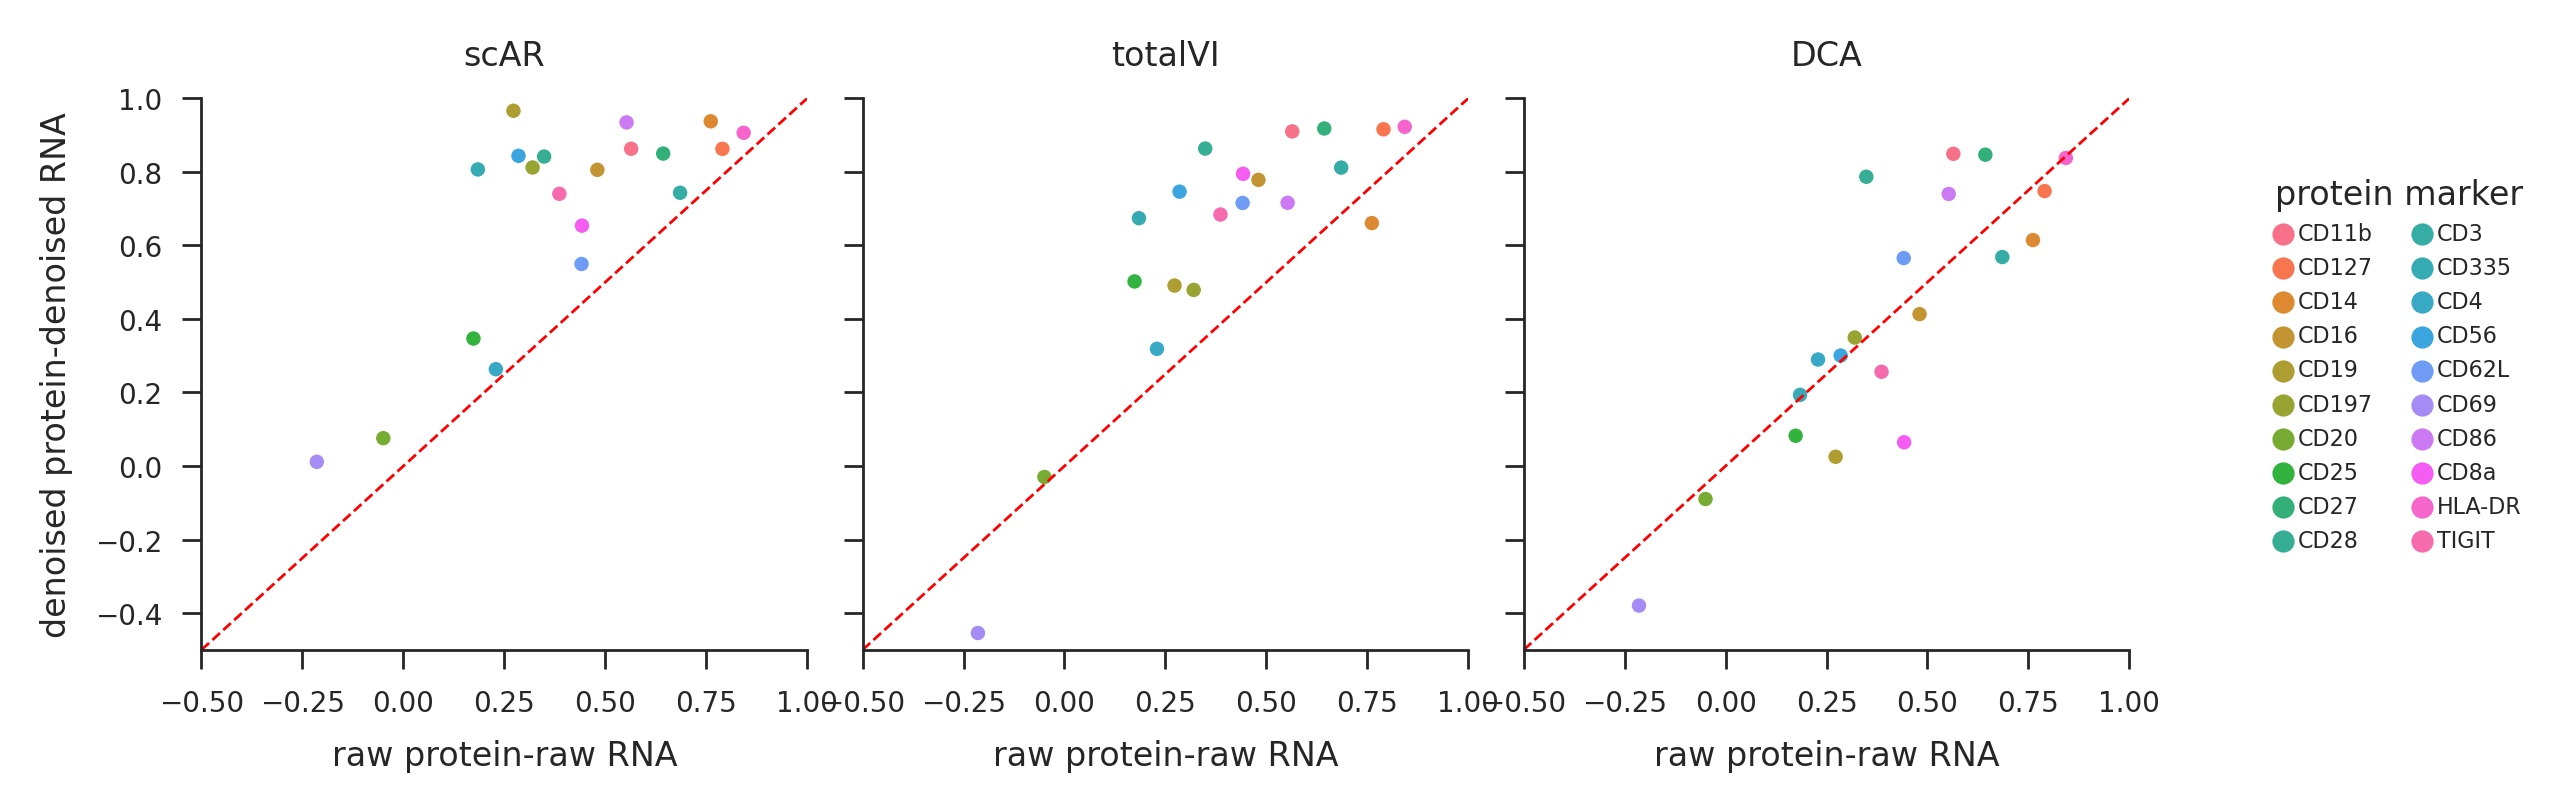

In [145]:
ax = sns.relplot(x= 'raw counts', y= 'corr', data=corr_scatterplot, 
                 hue='markers',
                 height=2,
                 aspect=0.9,
                 col ='meth', s=8);
[axe.plot([-0.5, 1],[-0.5, 1],ls='--',color='r',lw=0.5) for axe in ax.axes.flatten()]
ax.set(xlim=(-0.5,1),ylim=(-0.5,1));
ax.set_titles('{col_name}');
sns.move_legend(ax, "center right", bbox_to_anchor=(1.1, 0.55), ncol=2, title='protein marker', frameon=False, fontsize=4, markerscale=0.5, scatterpoints=1,);
ax.set(xlabel='raw protein-raw RNA', ylabel='denoised protein-denoised RNA');
plt.savefig('/da/ONC/bfx/research/shengca1/pipeline/ods-scar/manuscript/figures/Fig5.benchmarking/protein_RNA_correlation_denoised_both_27_01_2022.pdf')

In [140]:
corr_scatterplot = corr_all.reset_index()
corr_scatterplot = corr_scatterplot[corr_scatterplot['denoising']=='mRNA'][['meth', 'markers', 'corr']]
corr_scatterplot = corr_scatterplot.pivot(index='markers', columns=['meth'])
corr_scatterplot.columns = corr_scatterplot.columns.droplevel(0)
tmp = corr_scatterplot[['scAR', 'totalVI', 'DCA']].unstack().to_frame('corr').reset_index().set_index('markers')
corr_scatterplot = tmp.join(corr_scatterplot[['raw counts']], how='left')

corr_scatterplot = corr_scatterplot.reset_index()
corr_scatterplot = corr_scatterplot.fillna(0)
corr_scatterplot.head()

,markers,meth,corr,raw counts
0,CD11b,scAR,0.779709,0.564060
1,CD11b,totalVI,0.823418,0.564060
2,CD11b,DCA,0.821837,0.564060
3,CD127,scAR,0.800798,0.790089
4,CD127,totalVI,0.777766,0.790089


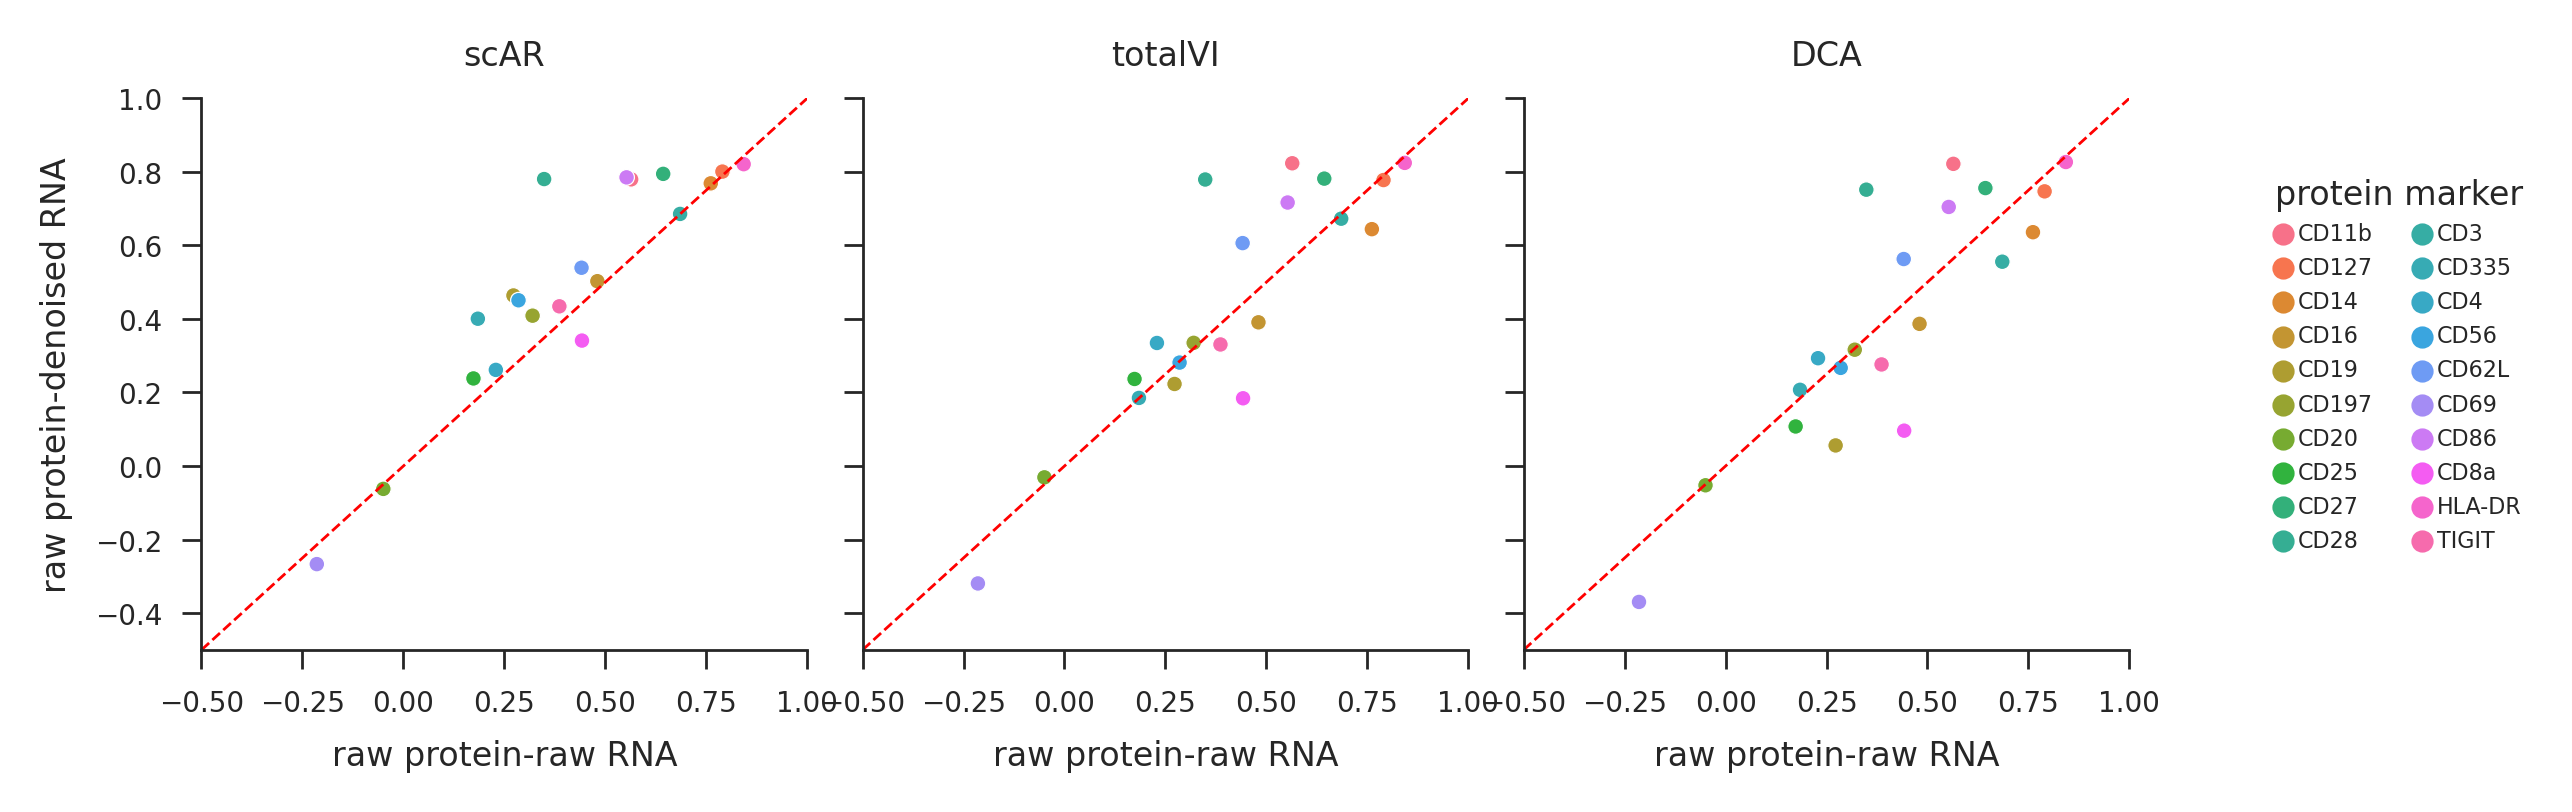

In [141]:
ax = sns.relplot(x= 'raw counts', y= 'corr', data=corr_scatterplot, 
                 hue='markers',
                 height=2,
                 aspect=0.9,
                 col ='meth', s=8);
[axe.plot([-0.5, 1],[-0.5, 1],ls='--',color='r',lw=0.5) for axe in ax.axes.flatten()]
ax.set(xlim=(-0.5,1),ylim=(-0.5,1));
ax.set_titles('{col_name}');
sns.move_legend(ax, "center right", bbox_to_anchor=(1.1, 0.55), ncol=2, title='protein marker', frameon=False, fontsize=4, markerscale=0.5, scatterpoints=1,);
ax.set(xlabel='raw protein-raw RNA', ylabel='raw protein-denoised RNA');
plt.savefig('/da/ONC/bfx/research/shengca1/pipeline/ods-scar/manuscript/figures/Fig5.benchmarking/protein_RNA_correlation_denoised_mRNA_27_01_2022.pdf')

In [142]:
corr_scatterplot = corr_all.reset_index()
corr_scatterplot = corr_scatterplot[corr_scatterplot['denoising']=='protein'][['meth', 'markers', 'corr']]
corr_scatterplot = corr_scatterplot.pivot(index='markers', columns=['meth'])
corr_scatterplot.columns = corr_scatterplot.columns.droplevel(0)
tmp = corr_scatterplot[['scAR', 'totalVI', 'DCA']].unstack().to_frame('corr').reset_index().set_index('markers')
corr_scatterplot = tmp.join(corr_scatterplot[['raw counts']], how='left')

corr_scatterplot = corr_scatterplot.reset_index()
corr_scatterplot = corr_scatterplot.fillna(0)
corr_scatterplot.head()

,markers,meth,corr,raw counts
0,CD11b,scAR,0.606533,0.564060
1,CD11b,totalVI,0.568924,0.564060
2,CD11b,DCA,0.559113,0.564060
3,CD127,scAR,0.850418,0.790089
4,CD127,totalVI,0.799556,0.790089


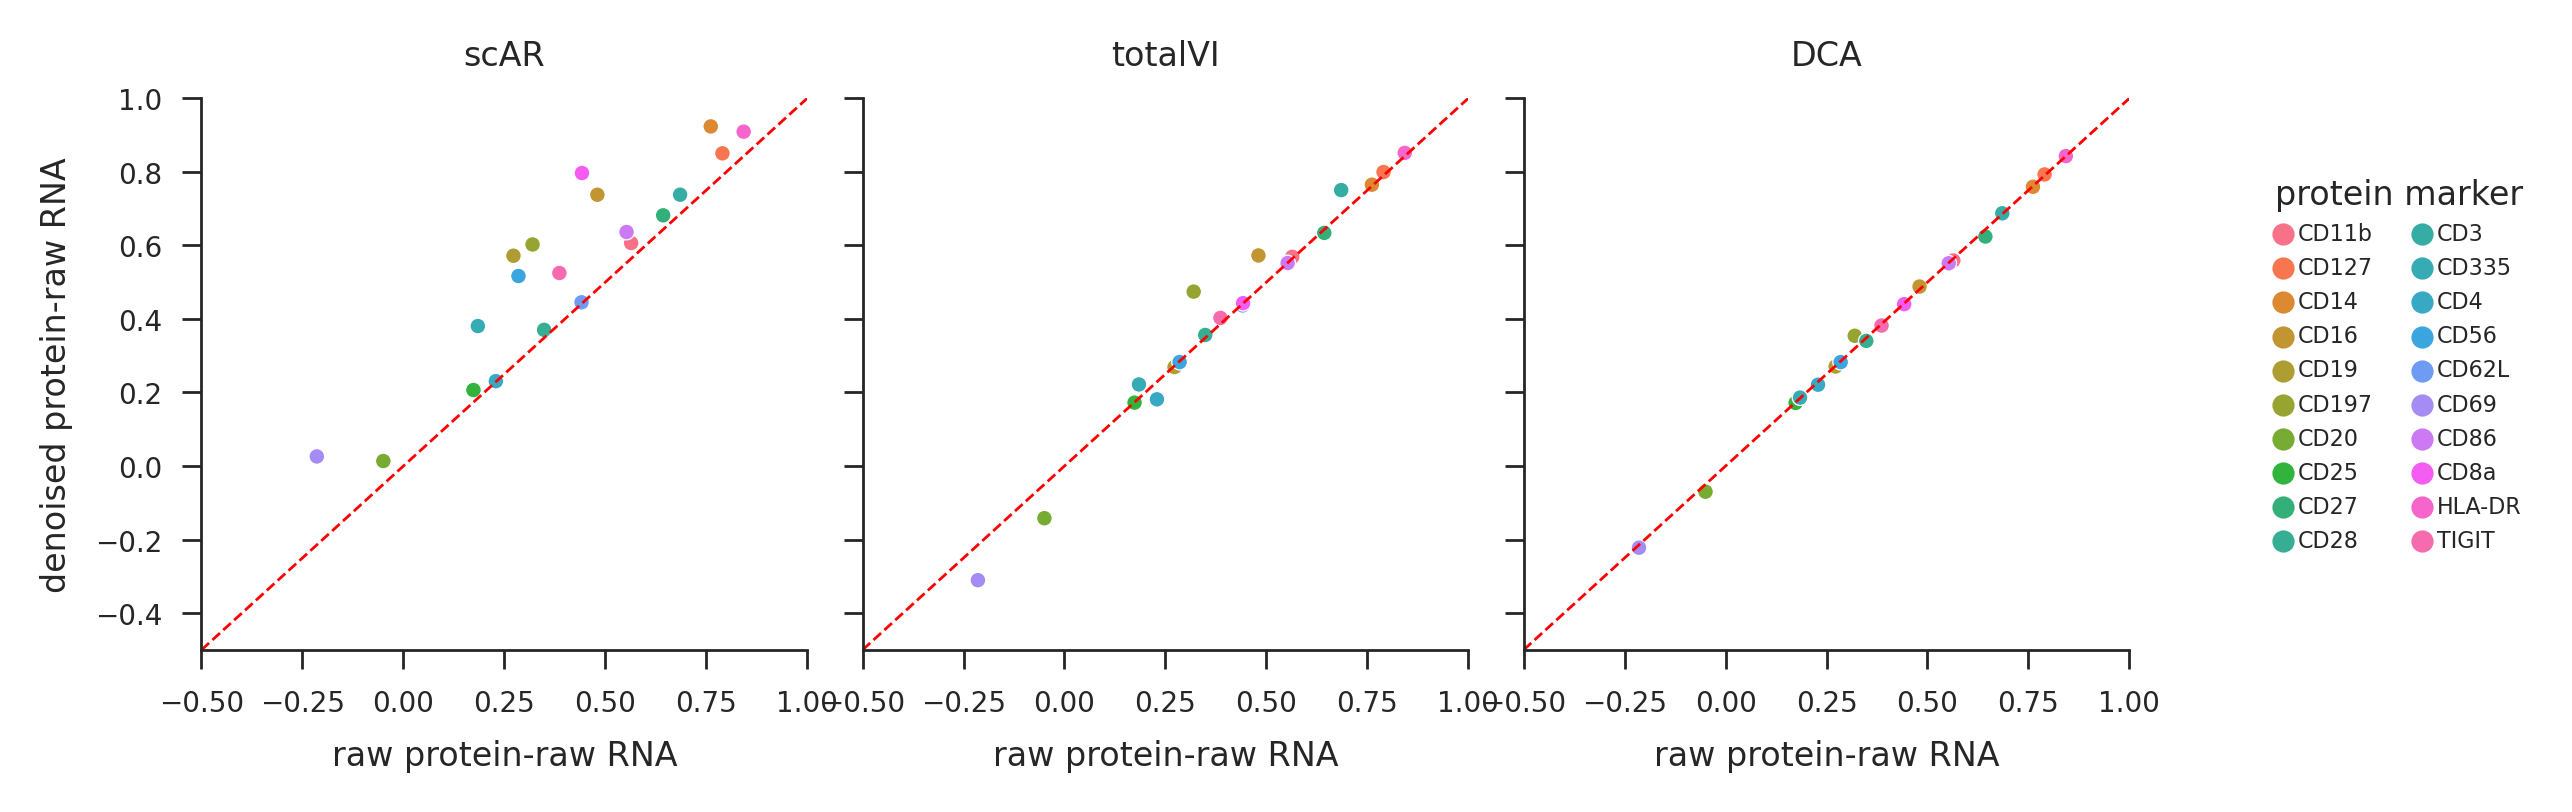

In [143]:
ax = sns.relplot(x= 'raw counts', y= 'corr', data=corr_scatterplot, 
                 hue='markers',
                 height=2,
                 aspect=0.9,
                 col ='meth', s=8);
[axe.plot([-0.5, 1],[-0.5, 1],ls='--',color='r',lw=0.5) for axe in ax.axes.flatten()]
ax.set(xlim=(-0.5,1),ylim=(-0.5,1));
ax.set_titles('{col_name}');
sns.move_legend(ax, "center right", bbox_to_anchor=(1.1, 0.55), ncol=2, title='protein marker', frameon=False, fontsize=4, markerscale=0.5, scatterpoints=1,);
ax.set(xlabel='raw protein-raw RNA', ylabel='denoised protein-raw RNA');
plt.savefig('/da/ONC/bfx/research/shengca1/pipeline/ods-scar/manuscript/figures/Fig5.benchmarking/protein_RNA_correlation_denoised_protein_27_01_2022.pdf')